<a href="https://colab.research.google.com/github/stefan-aleksandric/Keras-AiImageClassificationModel/blob/main/Projekat2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importovanje potrebnih biblioteka za rad i instaliranje paketa

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikeras

In [15]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Biblioteka za manipulaciju nad slikama
from tensorflow.keras.applications import NASNetMobile #importovanje NASNetMobile modela
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Conv2D, MaxPooling2D, Add, Input,  Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix

2. Putanja do dataset-a i priprema podataka

In [16]:
# Putanja do dataset-a na Google Drive-u
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Projekat2024/datasets/flower_photos'

# Parametri za obuku
batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a za augmentaciju i normalizaciju
train_datagen = ImageDataGenerator(
    rescale=1./255, # reskaliranje piksela na raspon od 0 do 1
    rotation_range=20, # nasumicno rotiranje slika od -20 do 20 stepeni
    zoom_range=0.2, # nasumicno zumiranje slika +- 20%
    horizontal_flip=True, # nasumicno horizontalno okretanje slika
    validation_split=0.2  # Podela za validaciju tj. 80% za obuku i 20% za validaciju
)

# Set za trening
training_set = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Set za validaciju
validation_set = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


3. NASNetMobile, zamrzavanje pretreniranog sloja i priprema modela

In [19]:
# Ucitavanje NASNetMobile modela
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Zamrzavanje svih slojeva baznog modela
for layer in base_model.layers:
    layer.trainable = False

# Odmrzavanje poslednjih 20 slojeva
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Kreiranje skip konekcije
skip_connection = Conv2D(128, (1, 1), padding='same')(base_model.output)
skip_connection = GlobalAveragePooling2D()(skip_connection)

# Dodavanje konvolucionih slojeva sa batch normalization
x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model.output)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# Dodavanje skip konekcije
x = Add()([x, skip_connection])

# Nastavak modela
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Kreiranje optimizatora sa specificnim learning_rate i momentum parametrima
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Kompajliranje modela
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Pregled modela
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_752            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation_752[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_753            │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_755            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_753[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_755[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_r

 Total params: 10,887,321 (41.53 MB)

 Trainable params: 6,786,005 (25.89 MB)

 Non-trainable params: 4,101,316 (15.65 MB)

4. Obuka modela i koriscenje EarlyStopping tehnike


In [20]:
# Broj epoha
epochs = 20

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # prati validacioni accuracy
    patience=5,              # zaustavlja ako se val_accuracy ne poboljsava u zadatim epochama
    restore_best_weights=True # vraca tezine modela iz epohe sa najboljom val_accuracy
)

# Model se trenira na training_set-u i validira na validation_set-u
history = model.fit(
    training_set,
    epochs=epochs,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 575s 6s/step - accuracy: 0.4893 - loss: 1.2668 - val_accuracy: 0.7429 - val_loss: 0.7076
Epoch 2/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.7500 - loss: 0.6728

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7500 - loss: 0.6728 - val_accuracy: 0.6667 - val_loss: 0.6919
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 532s 6s/step - accuracy: 0.7935 - loss: 0.5749 - val_accuracy: 0.8267 - val_loss: 0.5059
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8125 - loss: 0.4717 - val_accuracy: 0.8148 - val_loss: 0.4894
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - accuracy: 0.8360 - loss: 0.4613 - val_accuracy: 0.8267 - val_loss: 0.4642
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8438 - loss: 0.3613 - val_accuracy: 0.8889 - val_loss: 0.3393
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 536s 6s/step - accuracy: 0.8646 - loss: 0.3657 - val_accuracy: 0.8253 - val_loss: 0.4449
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8438 - loss: 0.5159 - val_accuracy: 0.8889 - val_loss: 0.6458
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 531s 6s/step - accuracy: 0.8776 - loss: 0.3448 - val_accuracy: 0.8267 - val_loss: 0.

5. Evaluacija modela i graficki prikaz loss i accuracy-ja

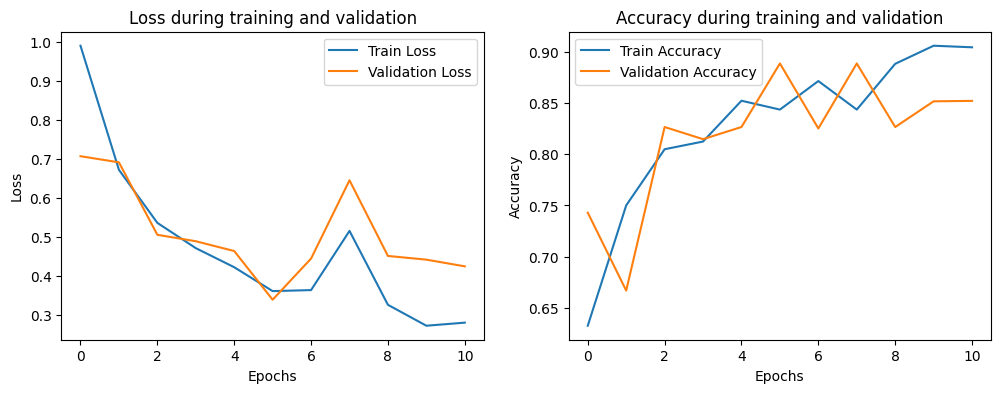

In [21]:
# Loss tokom epoha
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tacnost tokom epoha
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

6. Klasifikacioni izvestaj,loss,accuracy i konfuziona matrica

In [22]:
# Evaluiranje modela na testnom skupu
loss, accuracy = model.evaluate(validation_set, verbose=1)

# Predikcije modela
test_prediction = model.predict(validation_set)
test_prediction_classes = np.argmax(test_prediction, axis=1)

# Ucitavanje imena klasa
test_labels_classes = validation_set.classes
class_names = list(validation_set.class_indices.keys())

# Loss i Accuracy
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Klasifikacioni izvestaj
print("Klasifikacioni izvestaj:")
print(classification_report(test_labels_classes, test_prediction_classes, target_names=class_names))

# Konfuziona matrica
print("Konfuziona matrica:")
print(confusion_matrix(test_labels_classes, test_prediction_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.8033 - loss: 0.4940


23/23 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step
Test Loss: 0.4807
Test Accuracy: 0.8194
Klasifikacioni izvestaj:
              precision    recall  f1-score   support

       daisy       0.10      0.09      0.09       126
   dandelion       0.28      0.29      0.29       179
       roses       0.19      0.16      0.18       128
  sunflowers       0.19      0.21      0.20       139
      tulips       0.22      0.24      0.23       159

    accuracy                           0.21       731
   macro avg       0.20      0.20      0.20       731
weighted avg       0.20      0.21      0.20       731

Konfuziona matrica:
[[11 33 19 26 37]
 [24 52 26 33 44]
 [26 32 21 25 24]
 [20 35 25 29 30]
 [32 33 20 36 38]]


9. Isprobavanje random slika sa interneta (potrebno je zameniti image_url ako zelimo drugu sliku)

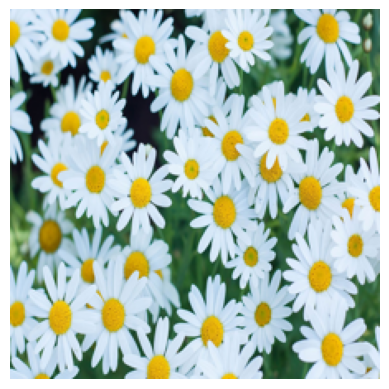

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Model predvidja da je ova slika: daisy


In [12]:
def load_image_from_url(url, target_size=(224, 224)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizacija piksela
    return img_array

# URL slike
image_url = 'https://cdn.britannica.com/36/82536-050-7E968918/Shasta-daisies.jpg'

# Ucitavanj slike
img_array = load_image_from_url(image_url)

# Prikaz slike
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

# Napravi predikciju
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
class_names = ['daisy', 'dandelion', 'roses', 'sunflower', 'tulips']

print(f"Model predvidja da je ova slika: {class_names[predicted_class[0]]}")

9.1. Isprobavanje na 16 random slika iz dataset-a

Found 3670 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


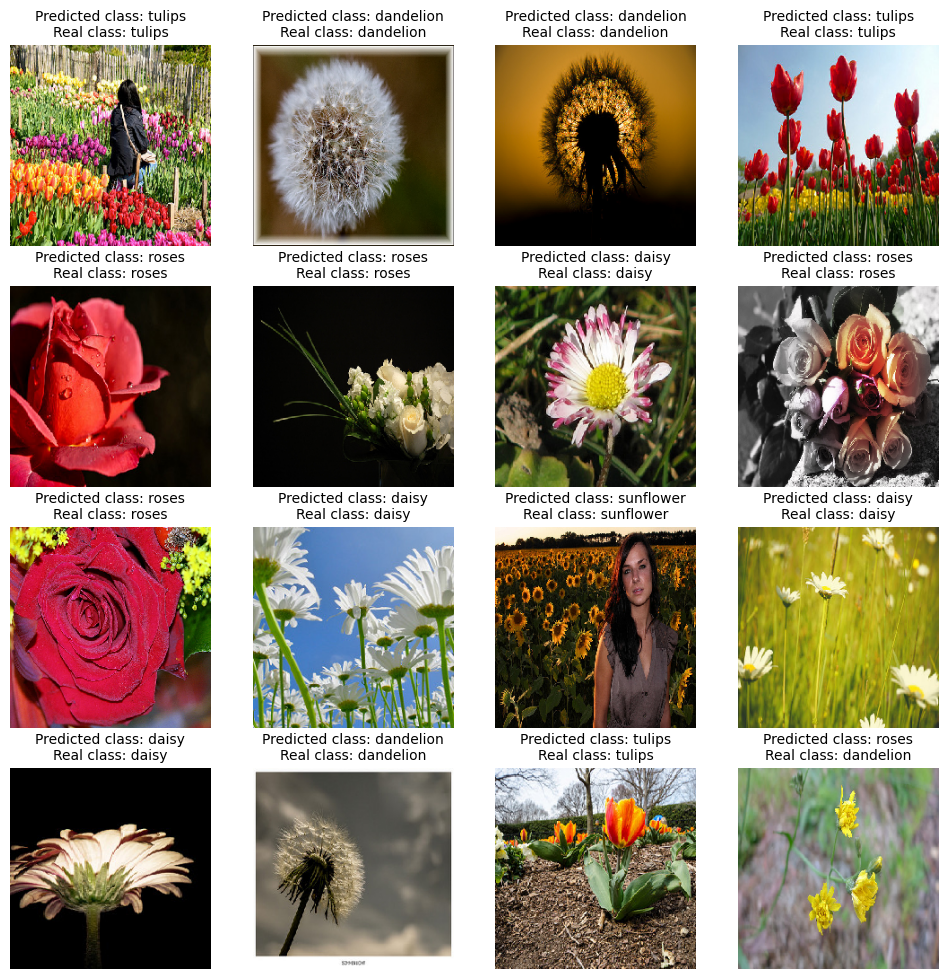

In [23]:
# Parametri za ucitavanje podataka
batch_size = 16
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a samo za validaciju bez augmentacije
datagen = ImageDataGenerator(rescale=1./255)

# Ucitavanje podataka iz dataset-a
data_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Mesanje slika za prikaz
)

# Ucitavanje jedne grupe slika (jedan batch)
images, labels = next(data_generator)

# Predikcija klasa za slike u batch-u
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Imena klasa
class_names = ['daisy', 'dandelion', 'roses', 'sunflower', 'tulips']

plt.figure(figsize=(12, 12))
for i in range(batch_size):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Predicted class: {class_names[predicted_classes[i]]}\nReal class: {class_names[np.argmax(labels[i])]}",fontsize=10)
    plt.axis('off')
plt.show()

10. RandomSearch -> Koristicemo KerasClassifier koji predstavlja wrapper klasu koja nam omogucava rad sa Random ili Grid Search-om i modelom, dok cemo sam model smestiti u funkciju koja prihvata parametre learning_rate i momentum

In [ ]:
def create_model(learning_rate,momentum):
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

10.2. Definisanje hiperametara za RandomSearch ili GridSearch

In [ ]:
# Definisanje opsega hiperparametara za Random Search
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'momentum': [0.85, 0.9, 0.95],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

10.3. GridSearch manuelna implementacija

In [ ]:
# Funkcija koja trenira model na prosledjenim parametrima i vraca accuracy
def evaluate_model(model, training_set, validation_set, epochs, batch_size):
    history = model.fit(training_set,
                        epochs=epochs,
                        steps_per_epoch=training_set.samples // training_set.batch_size,
                        validation_data=validation_set,
                        validation_steps=validation_set.samples // validation_set.batch_size,
                        callbacks=[early_stopping],
                        verbose=1)

    return history.history['val_accuracy'][-1]

In [ ]:
# Inicijalizacija ParameterGrid-a
grid = ParameterGrid(param_grid)

# Lista koja cuva rezultate
results = []

# Random Search
for params in grid:
    print(f"Training with parameters: {params}")

    learning_rate = params['learning_rate']
    momentum = params['momentum']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = create_model(learning_rate, momentum)
    val_accuracy = evaluate_model(model, training_set, validation_set, epochs, batch_size)

    results.append({
        'params': params,
        'val_accuracy': val_accuracy
    })

    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Sortiranje skorova
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Najbolji parametri
print("Best parameters:")
print(sorted_results[0])

Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001, 'momentum': 0.85}
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1248s 13s/step - accuracy: 0.2283 - loss: 1.6009 - val_accuracy: 0.2457 - val_loss: 1.5819
Epoch 2/10
 1/91 ━━━━━━━━━━━━━━━━━━━━ 18:03 12s/step - accuracy: 0.1562 - loss: 1.5939

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1562 - loss: 1.5939 - val_accuracy: 0.2222 - val_loss: 1.5811
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1156s 13s/step - accuracy: 0.2637 - loss: 1.5903 - val_accuracy: 0.2457 - val_loss: 1.5589
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.3125 - loss: 1.5688 - val_accuracy: 0.2963 - val_loss: 1.5572
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1212s 13s/step - accuracy: 0.2820 - loss: 1.5660 - val_accuracy: 0.2571 - val_loss: 1.5364
Validation Accuracy: 0.2571
Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001, 'momentum': 0.9}
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1264s 13s/step - accuracy: 0.2165 - loss: 1.6095 - val_accuracy: 0.2472 - val_loss: 1.5756
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.2188 - loss: 1.5956 - val_accuracy: 0.1852 - val_loss: 1.5918
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1158s 13s/step - accuracy: 0.2542 - loss: 1.5814 - val_accuracy: 0.2472 -